<a href="https://colab.research.google.com/github/crissolis17/EDA_CounterStrike/blob/main/Informe_Tecnico_FMY0100_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

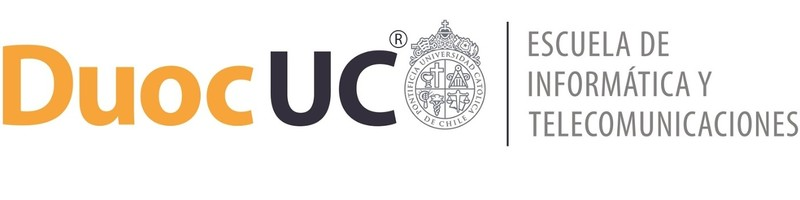

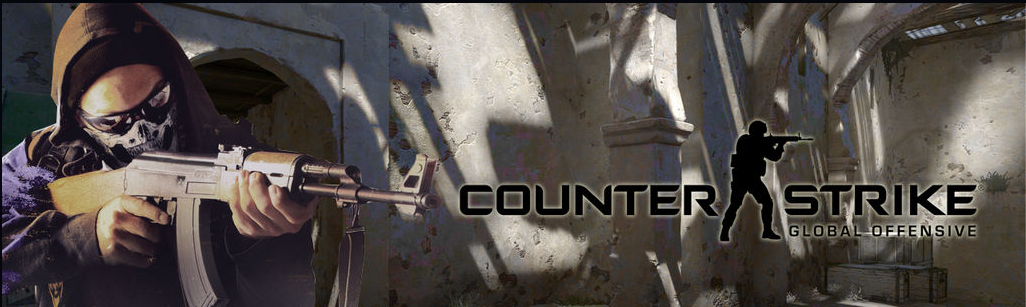

# Informe Técnico - Examen Transversal: Caso Counter Strike


Integrantes:
*Nicolas Cardenas
*Claudio Murua
*Cristian Solis

Docente:     

Sección: MLY0100 -

# Caso Fundamentos de Machine Learning

CONTEXTO CASO

Valve, los ha contactado como equipo de análisis de datos y modelado de Machine Learning para analizar y realizar modelos predictivos sobre los datos.

En cada partida de Counter Strike: GO dos equipos de 5 jugadores (denominados terroristas y contra-terroristas) se enfrentan.


El objetivo del equipo terrorista es plantar una bomba con timer de 45 segundos en uno de dos sitios específicos dentro de un mapa. Por otro lado, el objetivo del equipo contra-terrorista es evitar que la bomba sea plantada o desactivarla antes de que esta explote cuando ya ha sido plantada. Los datos a utilizar corresponden a sobre 7000 partidas del juego (con un máximo de 10 jugadores c/u)  


Los datos han sido extraídos de replays, los cuales son archivos propietarios con la información de cada una de las acciones realizadas por cada jugador dentro de una partida. Los replays han sido extraídos de la red utilizando un scrapper y pre-procesados utilizando un script.  



En este caso, la data corresponde a un archivo CSV con 79.157 filas, cada una correspondiente a un jugador dentro de una partida. El archivo contiene 29 columnas correspondientes a variables que describen las acciones del jugador dentro del juego.


$$
\begin{aligned}
&\begin{array}{cccc}
\hline \hline \text { Dato } & \text { Descripción } \\
\hline Map & \text {Nombre  del Mapa donde se jugó la partida}  \\
\hline \text{ Team} & \text { Nombre de equipo al que pertenece el jugador} \\
\hline \text{ InternalTeamId} & \text { Identificador del equipo al que pertenece el jugador.} \\
\hline \text{ MatchId} & \text { Identificador de la partida.} \\
\hline \text{ RoundId} & \text { Identificador de la ronda (los equipos se enfrentan en rondas de 5 partidas seguidas)} \\
\hline \text{ MatchWinner} & \text { Indica si el jugador ganó o no la partida.} \\
\hline \text{ RoundWinner} & \text { Indica si el jugador ganó o no la ronda analizada.} \\
\hline \text{ Survived} & \text { Indica si el jugador sobrevivió o no a la partida (sobrevivir no es sinónimo de ganar).} \\
\hline \text{ AbnormalMatch} & \text { Indica si la partida del jugador tuvo un error por conexión de red} \\
\hline \text{ TimeAlive} & \text { Indica el tiempo en segundos que el jugador estuvo vivo durante el juego} \\
\hline \text{ TravelledDistance} & \text { Distancia viajada por el jugador durante la partida.} \\
\hline \text{ RLethalGrenadesThrown/RNonLethalGrenadesThrown} & \text { Cantidad de granadas lanzadas, categorizadas en letales y no-letales.} \\
\hline \text{ PrimaryXXXX} & \text { Porcentaje de uso arma clasificada como primaria. Categorizada en AssaultRifle, SniperRifle, SMG, Heavy y Pistol.} \\
\hline \text{ [Match|Round] Assists} & \text { Cantidad de asistencias efectuadas por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] Kills} & \text { Cantidad de kills efectuados por el jugador durante la partida o la ronda.} \\
\hline \text{ [Match|Round] FlankKills} & \text { Cantidad de kills efectuados por el jugador sin que la víctima lo viese durante la partida o la ronda.} \\
\hline \text{ [Match|Round] HeadShots} & \text { Cantidad de kills efectuados por el jugador a través de un tiro en la cabeza durante la partida o la ronda.} \\
\hline \text{ RoundStartingEquipmentValue} & \text { Valor del equipamiento llevado por el jugador al inicio de la ronda.} \\
\hline \text{ TeamStartingEquipmentValue} & \text { Valor promedio del equipamiento llevado por el equipo del jugador al inicio de la ronda.} \\
\end{array}
\end{aligned}
$$

## Fase 1: Business Understanding

In [ ]:
# 1. Contexto del negocio
"""
Counter Strike: GO es un juego competitivo donde:
- Dos equipos de 5 jugadores (terroristas y contra-terroristas) se enfrentan
- El equipo terrorista busca plantar una bomba con temporizador de 45 segundos
- El equipo contra-terrorista intenta evitar que la bomba sea plantada o desactivarla
- Los datos analizados corresponden a 7,000 partidas con máximo 10 jugadores cada una
- La información proviene de replays procesados del juego
"""

# 2. Definición de objetivos de negocio

Objetivo de Clasificación:
- Predecir si un jugador ganará o no una ronda basado en sus estadísticas de juego
- Variable objetivo: RoundWinner (indica si el jugador ganó o no la ronda)

Objetivo de Regresión:
- Predecir el tiempo de supervivencia de un jugador durante una ronda
- Variable objetivo: TimeAlive (tiempo en segundos que el jugador estuvo vivo)


# 3. Evaluación de la situación actual

Recursos disponibles:
- Dataset con 79,157 filas (cada fila representa a un jugador en una partida)
- 29 columnas con variables que describen acciones, equipamiento y rendimiento
- Variables clave identificadas: mapa, equipo, eliminaciones, asistencias, equipamiento, etc.

Limitaciones:
- No hay información sobre estrategias específicas de equipo
- No se dispone de datos sobre la comunicación entre jugadores
- Es posible que existan variables latentes no capturadas en los datos


# 4. Hipótesis de negocio

Hipótesis para clasificación (RoundWinner):
1. Un mayor número de eliminaciones y asistencias aumenta la probabilidad de victoria
2. El valor del equipamiento inicial influye directamente en las posibilidades de ganar
3. Ciertos mapas pueden favorecer a un equipo específico (terroristas o contra-terroristas)
4. La eficiencia en headshots (disparos a la cabeza) es un indicador fuerte de victoria

Hipótesis para regresión (TimeAlive):
1. Jugadores con mejor equipamiento inicial sobreviven más tiempo
2. El equipo al que pertenece el jugador afecta su tiempo de supervivencia
3. Jugadores con mayor habilidad (medida por kills/headshots) tienden a sobrevivir más tiempo
4. Existe una relación entre el mapa de juego y el tiempo de supervivencia


# 5. Plan inicial para abordar el análisis

Enfoque propuesto:
1. Realizar análisis exploratorio para validar hipótesis iniciales
2. Preparar los datos mediante limpieza y transformación adecuadas
3. Desarrollar modelos de clasificación para predecir victoria (RoundWinner)
4. Desarrollar modelos de regresión para predecir tiempo de supervivencia (TimeAlive)
5. Evaluar los modelos y seleccionar los más efectivos
6. Extraer insights de negocio de los modelos desarrollados

Métricas de éxito:
- Para clasificación: accuracy, precision, recall, F1-score, AUC-ROC
- Para regresión: RMSE, MAE, R²


## Fase 2: Data Understanding

In [ ]:
# Insertar cuantos bloques de código consideren necesarios

# Se recomienda obtener estadísticos descriptivos para apoyar hipótesis inferenciales.
# Reconocer la naturaleza de los datos y como tratarlos en etapas posteriores y dar ideas de como se podría transformar.
# Identificar MissingValues, outliers, medidas de posición, medidas de dispersión etc.

In [ ]:
# CARGA DE LIBRERIAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [ ]:
# Cargar el dataset
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    name=fn
df = pd.read_csv(name, sep=";")

Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022 (5).csv


<ipython-input-4-8e039a4402a5>:6: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, sep=";")


In [ ]:
# 1. Información general del dataset
print(f"Dimensiones del dataset: {df.shape}")
print("\nColumnas del dataset:")
print(df.columns.tolist())
print("\nPrimeras 5 filas:")
print(df.head())

Dimensiones del dataset: (79157, 30)

Columnas del dataset:
['Unnamed: 0', 'Map', 'Team', 'InternalTeamId', 'MatchId', 'RoundId', 'RoundWinner', 'MatchWinner', 'Survived', 'AbnormalMatch', 'TimeAlive', 'TravelledDistance', 'RLethalGrenadesThrown', 'RNonLethalGrenadesThrown', 'PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol', 'FirstKillTime', 'RoundKills', 'RoundAssists', 'RoundHeadshots', 'RoundFlankKills', 'RoundStartingEquipmentValue', 'TeamStartingEquipmentValue', 'MatchKills', 'MatchFlankKills', 'MatchAssists', 'MatchHeadshots']

Primeras 5 filas:
   Unnamed: 0         Map       Team  InternalTeamId  MatchId  RoundId  \
0         600  de_inferno  Terrorist               1        4        1   
1         601  de_inferno  Terrorist               1        4        1   
2         602  de_inferno  Terrorist               1        4        1   
3         603  de_inferno  Terrorist               1        4        1   
4         604  de_inferno  Terr

In [ ]:
# 2. Análisis de tipos de datos y valores faltantes
print("\nInformación de tipos de datos:")
print(df.info())

print("\nValores nulos por columna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


Información de tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79157 entries, 0 to 79156
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   79157 non-null  int64  
 1   Map                          79157 non-null  object 
 2   Team                         79155 non-null  object 
 3   InternalTeamId               79157 non-null  int64  
 4   MatchId                      79157 non-null  int64  
 5   RoundId                      79157 non-null  int64  
 6   RoundWinner                  79157 non-null  object 
 7   MatchWinner                  79156 non-null  object 
 8   Survived                     79157 non-null  bool   
 9   AbnormalMatch                79157 non-null  bool   
 10  TimeAlive                    79157 non-null  object 
 11  TravelledDistance            79157 non-null  object 
 12  RLethalGrenadesThrown        79157 non-nul

In [ ]:
# 3. Estadísticas descriptivas
print("\nEstadísticas descriptivas para variables numéricas:")
print(df.describe())



Estadísticas descriptivas para variables numéricas:
          Unnamed: 0  InternalTeamId       MatchId       RoundId  \
count   79157.000000    79157.000000  79157.000000  79157.000000   
mean    60570.193640        1.500006    250.525033     12.765517   
std     36436.598386        0.500003    149.557804      7.432837   
min       600.000000        1.000000      4.000000      1.000000   
25%     30830.000000        1.000000    128.000000      6.000000   
50%     56720.000000        2.000000    236.000000     12.000000   
75%     90639.000000        2.000000    373.000000     19.000000   
max    123779.000000        2.000000    511.000000     36.000000   

       RLethalGrenadesThrown  RNonLethalGrenadesThrown  PrimaryAssaultRifle  \
count           79157.000000              79157.000000         79157.000000   
mean                0.498667                  1.258057             0.675363   
std                 0.597985                  1.184909             0.464125   
min               

In [ ]:
# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())


Valores nulos por columna:
Unnamed: 0                     0
Map                            0
Team                           2
InternalTeamId                 0
MatchId                        0
RoundId                        0
RoundWinner                    0
MatchWinner                    1
Survived                       0
AbnormalMatch                  0
TimeAlive                      0
TravelledDistance              0
RLethalGrenadesThrown          0
RNonLethalGrenadesThrown       0
PrimaryAssaultRifle            0
PrimarySniperRifle             0
PrimaryHeavy                   0
PrimarySMG                     0
PrimaryPistol                  0
FirstKillTime                  0
RoundKills                     0
RoundAssists                   0
RoundHeadshots                 0
RoundFlankKills                0
RoundStartingEquipmentValue    0
TeamStartingEquipmentValue     0
MatchKills                     0
MatchFlankKills                0
MatchAssists                   0
MatchHeadshots 


Distribución de mapas (Map):
Map
de_inferno    28869
de_dust2      19120
de_mirage     19019
de_nuke       12149
Name: count, dtype: int64


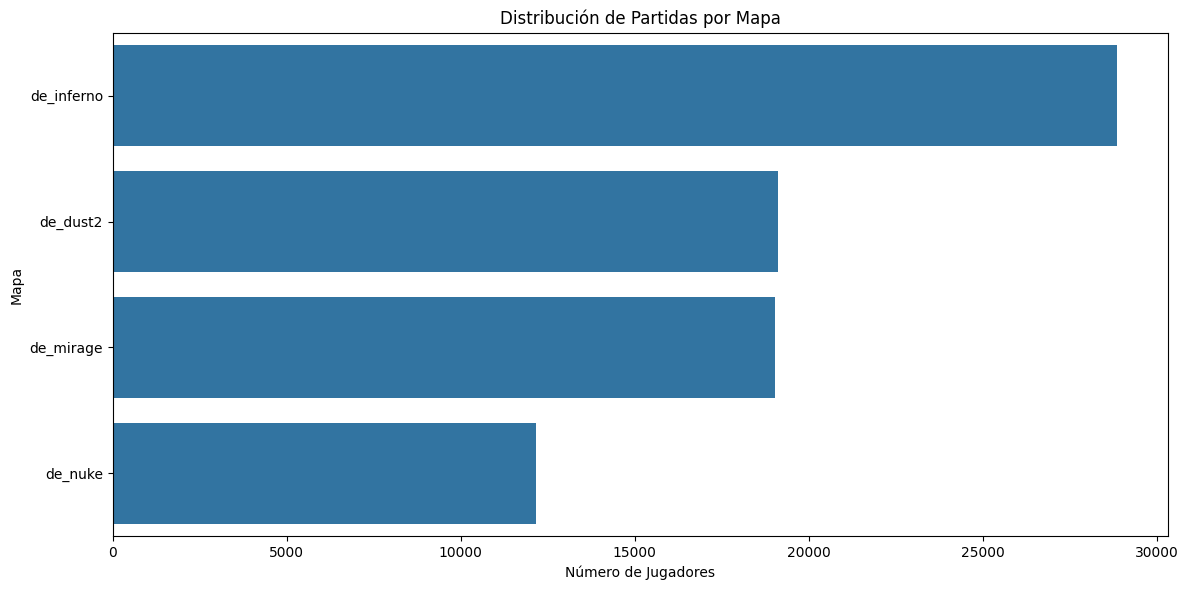


Distribución de equipos (Team):
Team
Terrorist           39591
CounterTerrorist    39564
Name: count, dtype: int64


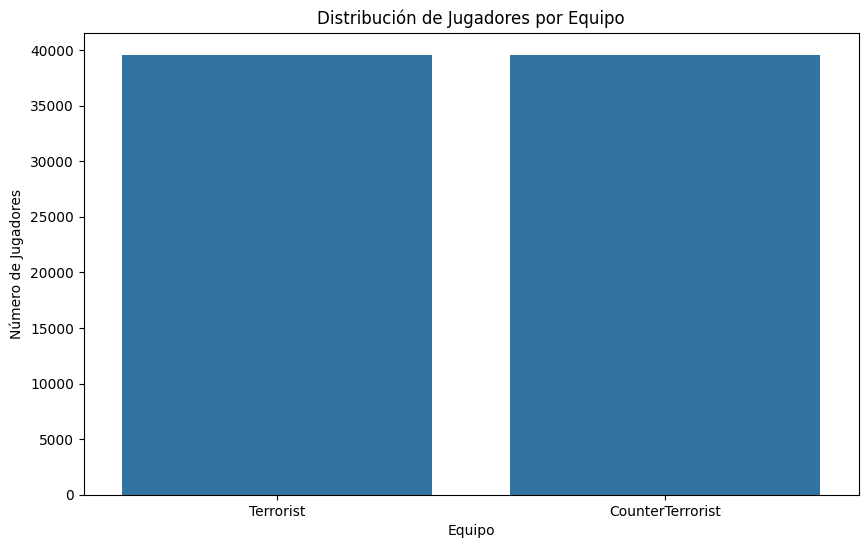

In [ ]:
# 4. Análisis de la distribución de variables categóricas
print("\nDistribución de mapas (Map):")
map_counts = df['Map'].value_counts()
print(map_counts)

plt.figure(figsize=(12, 6))
sns.countplot(y='Map', data=df, order=df['Map'].value_counts().index)
plt.title('Distribución de Partidas por Mapa')
plt.xlabel('Número de Jugadores')
plt.ylabel('Mapa')
plt.tight_layout()
plt.show()

print("\nDistribución de equipos (Team):")
team_counts = df['Team'].value_counts()
print(team_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='Team', data=df)
plt.title('Distribución de Jugadores por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Número de Jugadores')
plt.show()

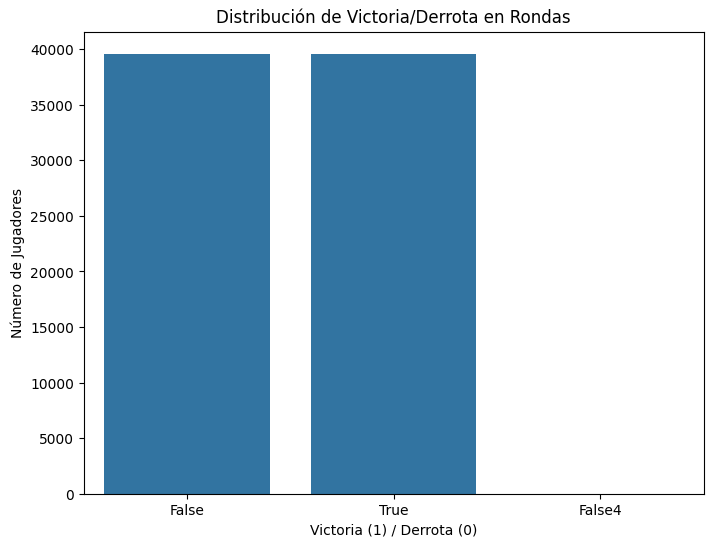

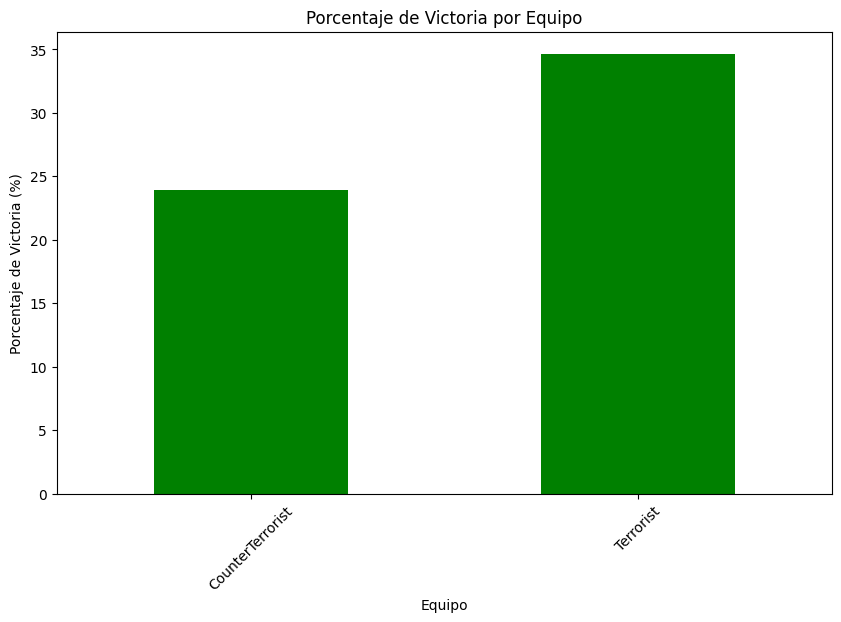

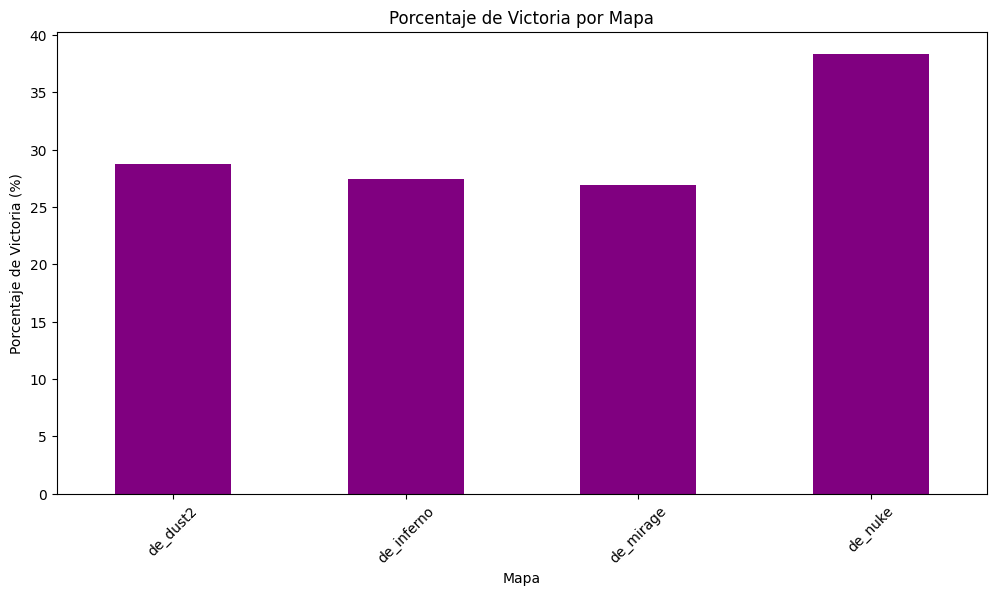

In [ ]:
# 5. Análisis de la variable objetivo - Clasificación (RoundWinner)
plt.figure(figsize=(8, 6))
sns.countplot(x='RoundWinner', data=df)
plt.title('Distribución de Victoria/Derrota en Rondas')
plt.xlabel('Victoria (1) / Derrota (0)')
plt.ylabel('Número de Jugadores')
plt.show()

# Tasa de victoria por equipo
plt.figure(figsize=(10, 6))
victory_by_team = pd.crosstab(df['Team'], df['RoundWinner'])
victory_percentage = victory_by_team.div(victory_by_team.sum(axis=1), axis=0) * 100
victory_percentage[1].plot(kind='bar', color='green')
plt.title('Porcentaje de Victoria por Equipo')
plt.xlabel('Equipo')
plt.ylabel('Porcentaje de Victoria (%)')
plt.xticks(rotation=45)
plt.show()

# Tasa de victoria por mapa
plt.figure(figsize=(12, 6))
victory_by_map = pd.crosstab(df['Map'], df['RoundWinner'])
victory_percentage_map = victory_by_map.div(victory_by_map.sum(axis=1), axis=0) * 100
victory_percentage_map[1].plot(kind='bar', color='purple')
plt.title('Porcentaje de Victoria por Mapa')
plt.xlabel('Mapa')
plt.ylabel('Porcentaje de Victoria (%)')
plt.xticks(rotation=45)
plt.show()

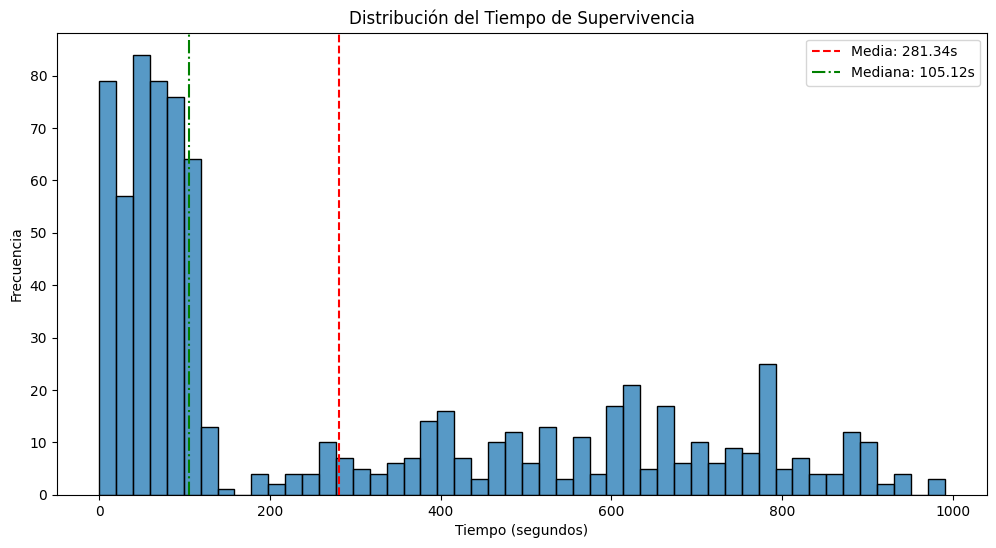

In [ ]:
# 6. Análisis de la variable objetivo - Regresión (TimeAlive) - Versión optimizada
plt.figure(figsize=(12, 6))

# Convert 'TimeAlive' column to numeric, handling errors
df['TimeAlive'] = pd.to_numeric(df['TimeAlive'], errors='coerce')

# Usar bins para reducir la carga computacional
bins = 50
sns.histplot(df['TimeAlive'], kde=False, bins=bins)  # Quitar kde o establecer a False para mayor velocidad

# Calcular estadísticas antes para evitar cálculos repetidos
mean_time = df['TimeAlive'].mean()
median_time = df['TimeAlive'].median()

plt.title('Distribución del Tiempo de Supervivencia')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia')
plt.axvline(mean_time, color='red', linestyle='--', label=f'Media: {mean_time:.2f}s')
plt.axvline(median_time, color='green', linestyle='-.', label=f'Mediana: {median_time:.2f}s')
plt.legend()
plt.show()

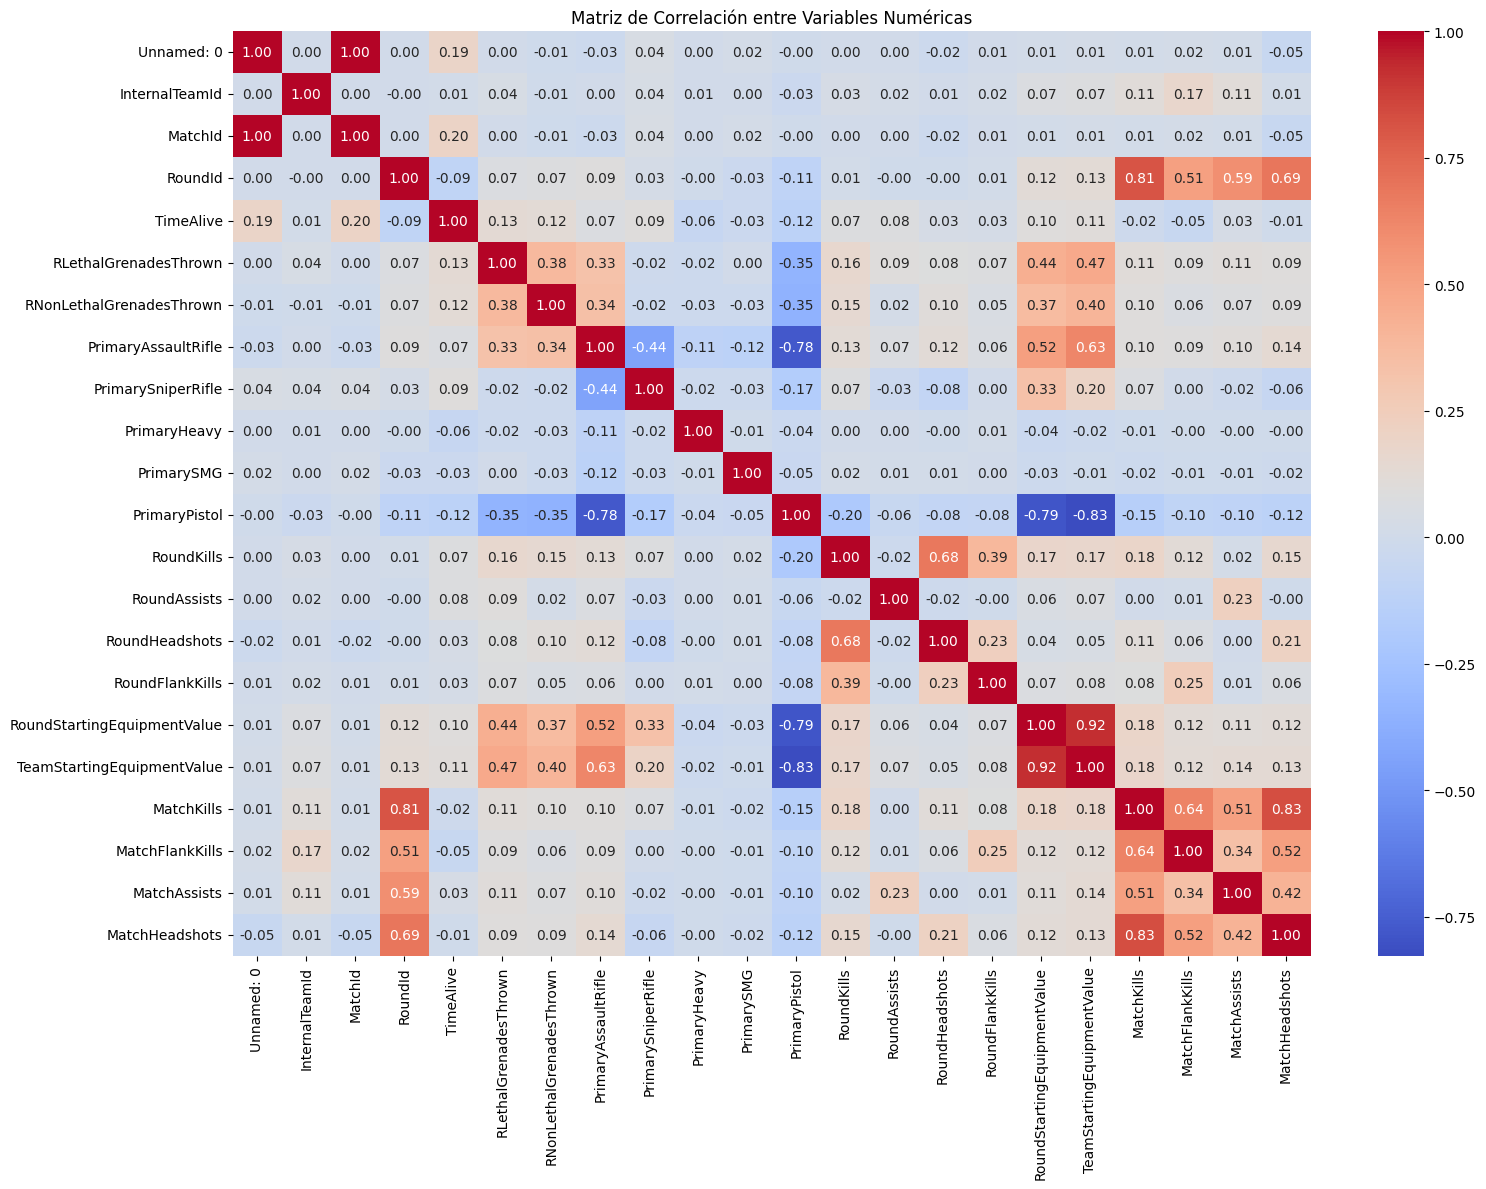

In [ ]:
# 7. Análisis de correlación entre variables numéricas
# Seleccionar solo columnas numéricas para la correlación
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.tight_layout()
plt.show()

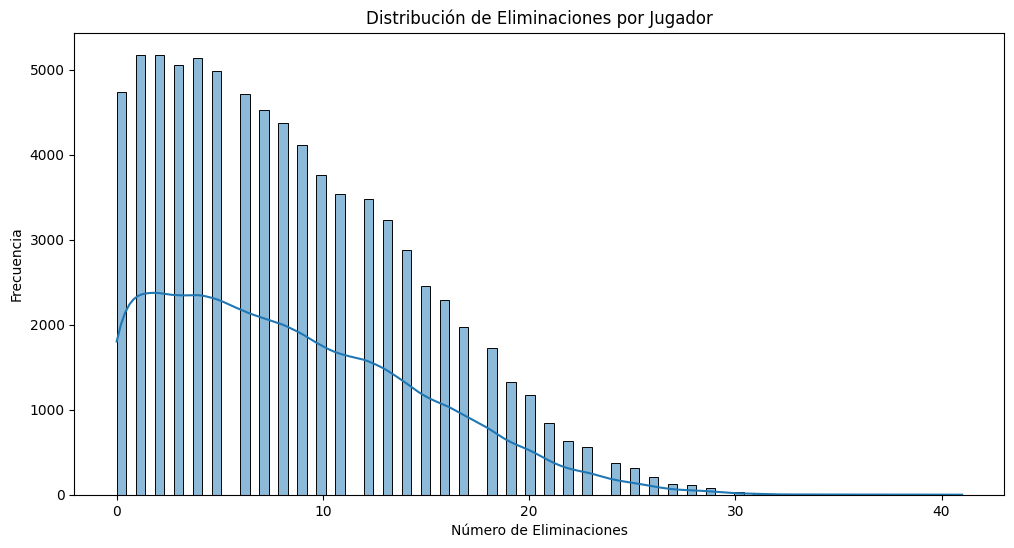

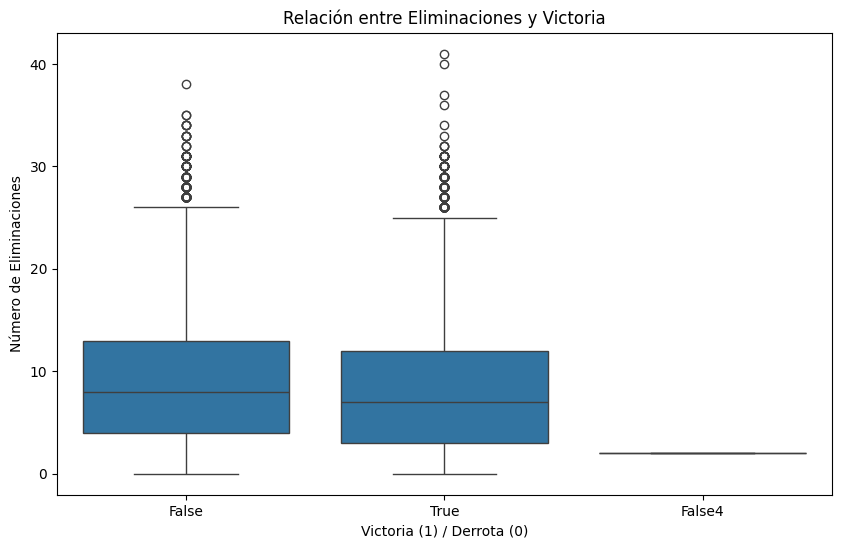

In [ ]:
# 8. Análisis de variables de rendimiento clave
# Análisis de kills
plt.figure(figsize=(12, 6))
# Updated column name to 'MatchKills'
sns.histplot(df['MatchKills'], kde=True)
plt.title('Distribución de Eliminaciones por Jugador')
plt.xlabel('Número de Eliminaciones')
plt.ylabel('Frecuencia')
plt.show()

# Relación entre kills y victoria
plt.figure(figsize=(10, 6))
# Updated column name to 'MatchKills'
sns.boxplot(x='RoundWinner', y='MatchKills', data=df)
plt.title('Relación entre Eliminaciones y Victoria')
plt.xlabel('Victoria (1) / Derrota (0)')
plt.ylabel('Número de Eliminaciones')
plt.show()

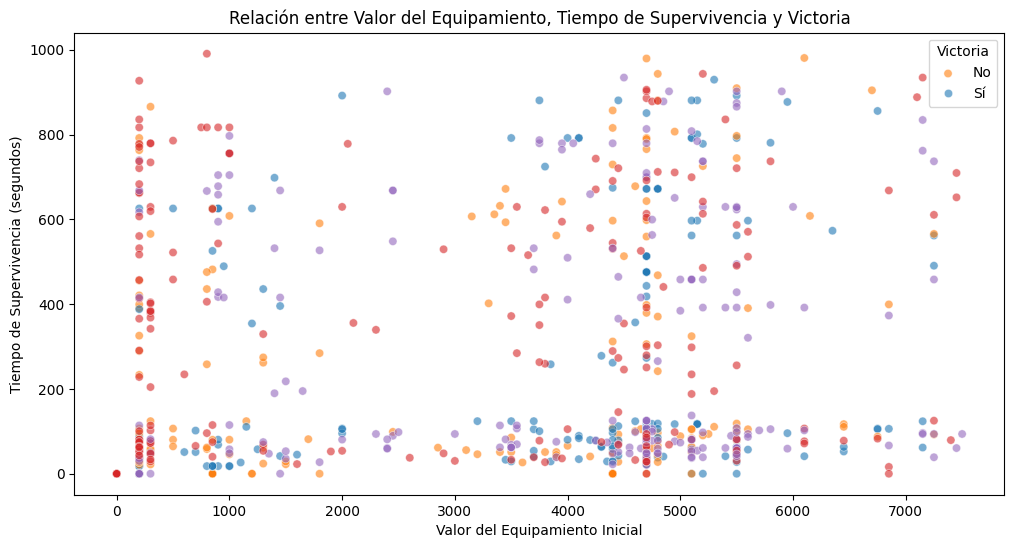

In [ ]:
# 9. Análisis del equipamiento y su influencia
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RoundStartingEquipmentValue', y='TimeAlive', hue='RoundWinner', data=df, alpha=0.6)
plt.title('Relación entre Valor del Equipamiento, Tiempo de Supervivencia y Victoria')
plt.xlabel('Valor del Equipamiento Inicial')
plt.ylabel('Tiempo de Supervivencia (segundos)')
plt.legend(title='Victoria', labels=['No', 'Sí'])
plt.show()

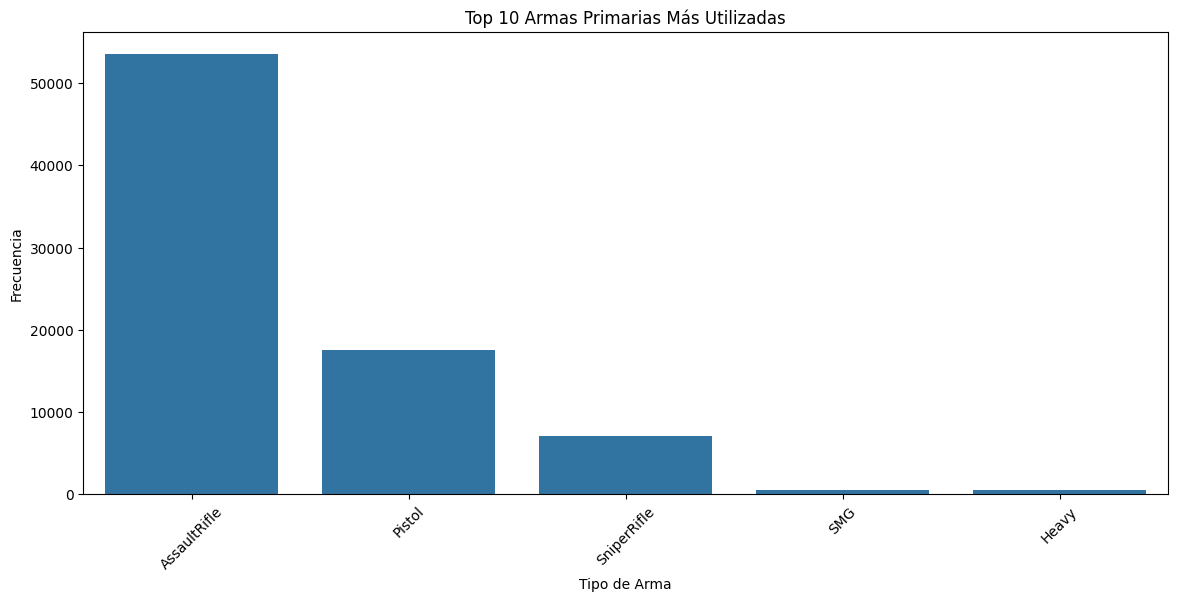

In [ ]:
# 10. Análisis de armas primarias
# Top 10 armas más utilizadas
plt.figure(figsize=(14, 6))

# Combinar las columnas 'Primary...' en una sola columna 'PrimaryWeapon'
primary_weapon_cols = ['PrimaryAssaultRifle', 'PrimarySniperRifle', 'PrimaryHeavy', 'PrimarySMG', 'PrimaryPistol']
df['PrimaryWeapon'] = df[primary_weapon_cols].idxmax(axis=1).str.replace('Primary', '') # Get the column name with the max value and remove 'Primary'

# Obtener las 10 armas primarias más usadas
top_weapons = df['PrimaryWeapon'].value_counts().head(10)

# Graficar
sns.barplot(x=top_weapons.index, y=top_weapons.values)
plt.title('Top 10 Armas Primarias Más Utilizadas')
plt.xlabel('Tipo de Arma')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

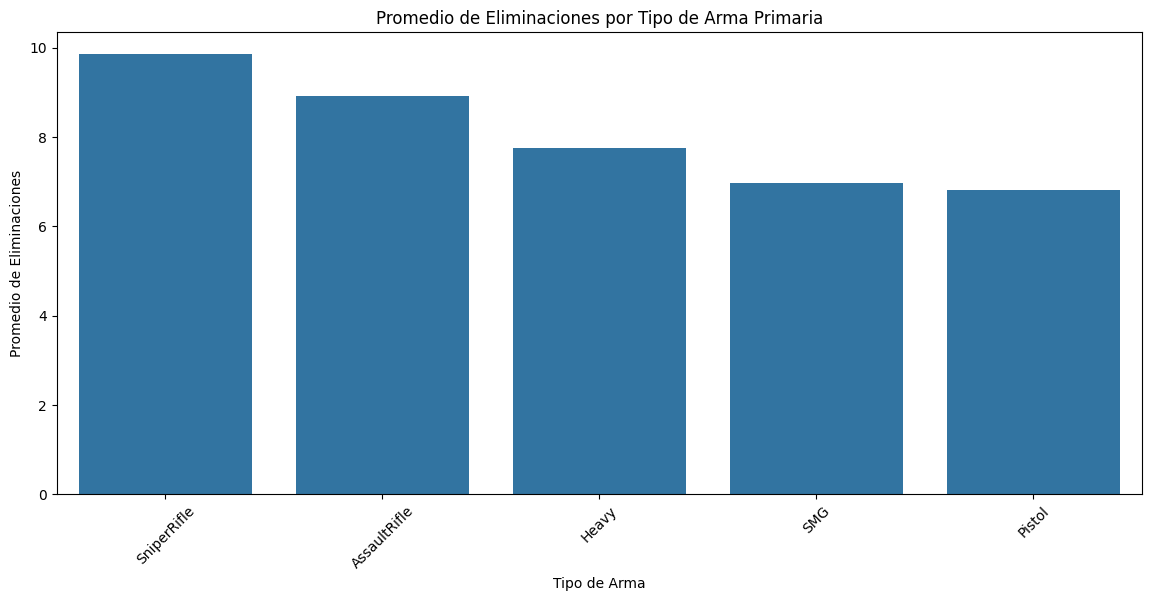

In [ ]:
# Eficiencia de eliminaciones por tipo de arma
weapon_efficiency = df.groupby('PrimaryWeapon')['MatchKills'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(14, 6))
sns.barplot(x=weapon_efficiency.index, y=weapon_efficiency.values)
plt.title('Promedio de Eliminaciones por Tipo de Arma Primaria')
plt.xlabel('Tipo de Arma')
plt.ylabel('Promedio de Eliminaciones')
plt.xticks(rotation=45)
plt.show()

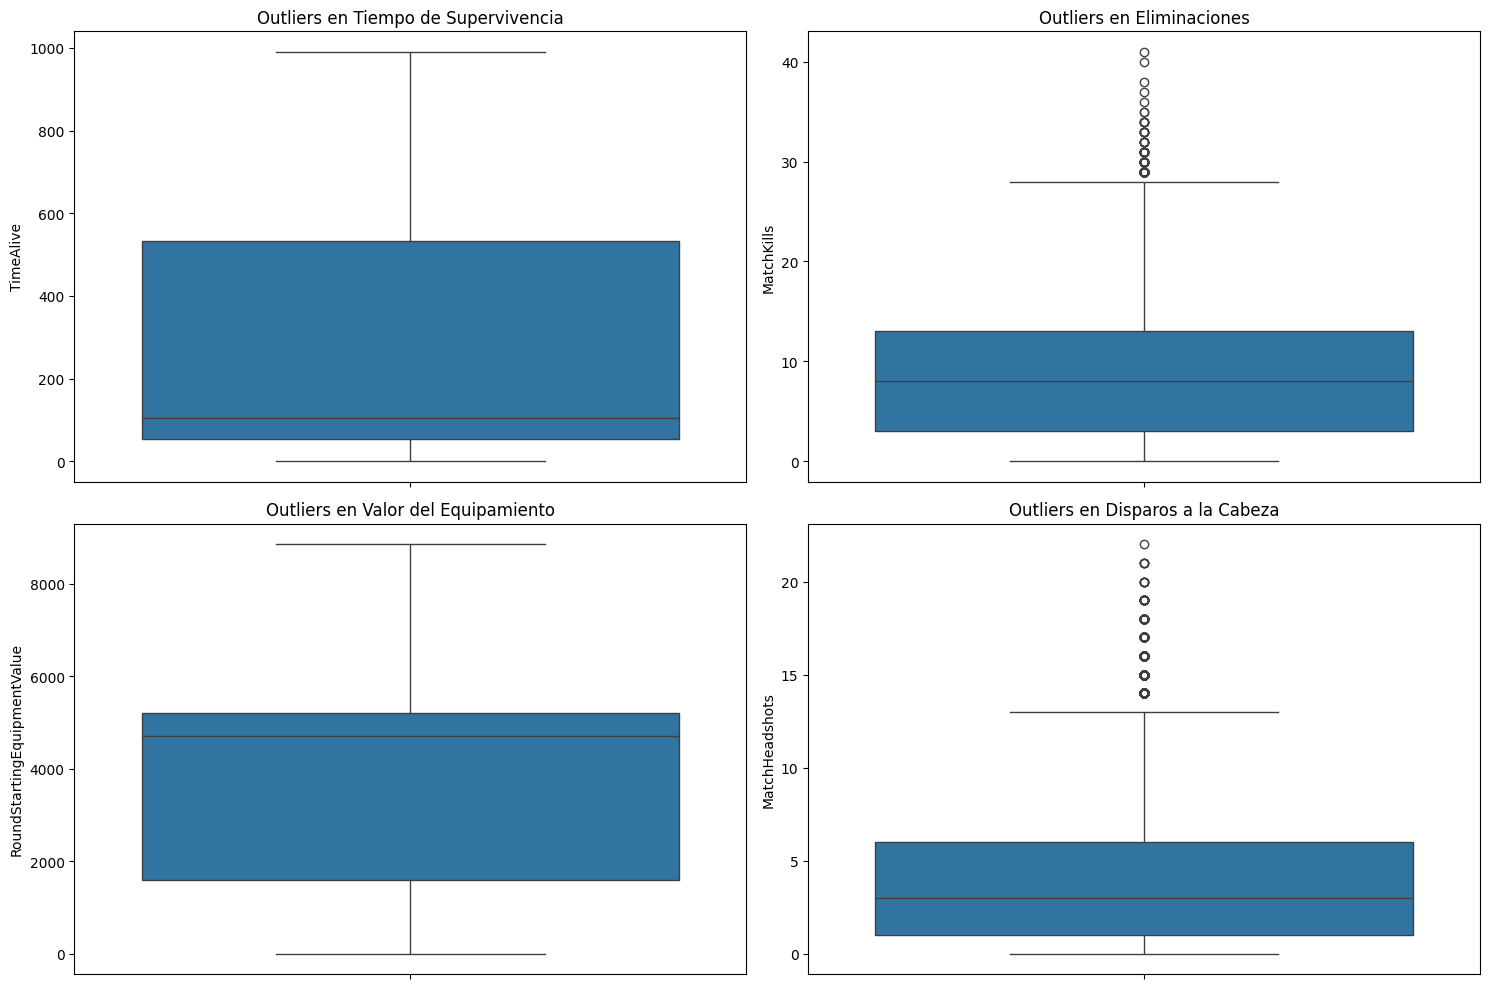

In [ ]:
# 11. Análisis de outliers en variables clave
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(y=df['TimeAlive'])
plt.title('Outliers en Tiempo de Supervivencia')

plt.subplot(2, 2, 2)
sns.boxplot(y=df['MatchKills'])
plt.title('Outliers en Eliminaciones')

plt.subplot(2, 2, 3)
sns.boxplot(y=df['RoundStartingEquipmentValue'])
plt.title('Outliers en Valor del Equipamiento')

plt.subplot(2, 2, 4)
sns.boxplot(y=df['MatchHeadshots'])
plt.title('Outliers en Disparos a la Cabeza')

plt.tight_layout()
plt.show()

## Fase 3: Data Preparation

In [ ]:
# Insertar cuantos bloques de código consideren necesarios

# Se recomienda considerar todas las transformaciones necesarias para obtener la data lo más limpia posible.
# Realizar tratamiento a todos los datos que consideren necesarios.